In [1]:
!pip install --upgrade pip
!pip install tensorflow

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\vdako\anaconda3\envs\sam-model-env\python.exe -m pip install --upgrade pip


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/fb/59/3eb58629e3749d9f4fc1e522487af369f9bd4c451f465d3054961fab6bf8/tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5b/6f/8b125d126d54061c0be610b135aaf2f8960f55c2e185ac32445e4a5012d5/tensorflow-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/38/ba/dd4d998a852451e98dc009ecb208bbb0eeb0c8252dc35b7c4e1050762b36/tensorflow_intel-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
supervision 0.12.0 requires pillow<9.0.0,>=8.4.0, but you have pillow 10.0.0 which is incompatible.


In [1]:
import sys
import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
#print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Tensor Flow Version: 2.13.0

Python 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
import pickle
dict = pickle.load(open('california-housing-dataset.pkl', 'rb'))
x_train, y_train = dict['x_train'], dict['y_train']
x_test, y_test = dict['x_test'], dict['y_test']

print(x_train.shape, y_train.shape)
print(x_train[1,:], y_train[1])

(15480, 8) (15480,)
[   2.7639        9.            8.75862069    1.72413793   66.
    2.27586207   39.04       -122.69      ] 1.125


In [16]:
features = ['MedInc', 'HouseAge' ,'AveRooms' ,'AveBedrms' ,'Population', 'AveOccup' ,'Latitude' ,'Longitude' ]

def show_dataset_min_and_max(x, y, features):
    for i in range(len(features)):
        x[:,i] = x[:,i]
        print('{}; Max:{}; Min:{}'.format(features[i], max(x[:,i]), min(x[:,i])))
    print('\nMax Price: {}; Min Price: {}'.format(max(y), min(y[:])))

    

#### Non-Normalized Values


In [17]:
show_dataset_min_and_max(x_train, y_train, features)

MedInc; Max:15.0001; Min:0.4999
HouseAge; Max:52.0; Min:1.0
AveRooms; Max:141.9090909090909; Min:0.8461538461538461
AveBedrms; Max:34.06666666666667; Min:0.3333333333333333
Population; Max:35682.0; Min:5.0
AveOccup; Max:1243.3333333333333; Min:0.6923076923076923
Latitude; Max:41.95; Min:32.54
Longitude; Max:-114.31; Min:-124.35

Max Price: 5.00001; Min Price: 0.14999


#### Normalized Values


In [18]:
x_train_n = np.zeros((15480,8))

x_train_n[:,0] = x_train[:,0]/15.1
x_train_n[:,1] = x_train[:,1]/52
x_train_n[:,2] = x_train[:,2]/142
x_train_n[:,3] = x_train[:,3]/34.1
x_train_n[:,4] = x_train[:,4]/35682.0
x_train_n[:,5] = x_train[:,5]/1243.4
x_train_n[:,6] = (x_train[:,6]-32.5)/10
x_train_n[:,7] = (x_train[:,7]+124.4)/10.1

y_train_n= y_train[:]/5.1

In [12]:
show_dataset_min_and_max(x_train_n, y_train_n, features)

MedInc; Max:0.9933841059602649; Min:0.03310596026490066
HouseAge; Max:1.0; Min:0.019230769230769232
AveRooms; Max:0.999359795134443; Min:0.005958829902491874
AveBedrms; Max:0.9990224828934506; Min:0.009775171065493644
Population; Max:1.0; Min:0.00014012667451376043
AveOccup; Max:0.9999463835719263; Min:0.0005567859838408334
Latitude; Max:0.9450000000000003; Min:0.003999999999999915
Longitude; Max:0.9990099009900993; Min:0.004950495049506076
Max Price: 0.9803941176470589; Min Price: 0.029409803921568632


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
tf.random.set_seed(1234)

In [39]:
def initialize_sequential_model(layer_sizes, activation):
    model = Sequential()
    for size in layer_sizes:
        if not model.layers :
            model.add(Dense(size, activation=activation, input_shape=(8,)))
        else:
            model.add(Dense(size, activation=activation))
        #if not model.layers checks whether the model already has layers defined
    
    return model

def visualize_predictions(labels_predicted, y_train):
    plt.plot(labels_predicted, y_train,'.', alpha =0.1)
    plt.plot(y_train, y_train)
    plt.title('price')
    plt.show()

def plot_training_history(train_set_error, val_set_error, history, title='y_absolute_error'):
    plt.plot(history.history[train_set_error])
    plt.plot(history.history[val_set_error])
    plt.title(title)
    plt.ylabel('absolute_error')
    plt.xlabel('epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [40]:
# define the keras model
layer_sizes = [256, 512, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
activation = 'elu'
model = initialize_sequential_model(layer_sizes, activation)

#model = load_model("models/full_20231018_adam")
model.summary()

model.compile(loss='mean_squared_error', 
              optimizer= tf.keras.optimizers.Adam(),  #"adam" 
              metrics=['mean_absolute_error','mean_absolute_percentage_error']
             )


# fit the keras model on the dataset
history = model.fit(x_train_n[:,:], #training data
                    y_train_n[:],  #Labels
                    epochs=200,
                    batch_size=128,
                    verbose=0.2,
                    validation_split = 0.1
                   )

model.save("model1_adam")


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 256)               2304      
                                                                 
 dense_79 (Dense)            (None, 512)               131584    
                                                                 
 dense_80 (Dense)            (None, 1024)              525312    
                                                                 
 dense_81 (Dense)            (None, 512)               524800    
                                                                 
 dense_82 (Dense)            (None, 256)               131328    
                                                                 
 dense_83 (Dense)            (None, 128)               32896     
                                                                 
 dense_84 (Dense)            (None, 64)               

KeyboardInterrupt: 

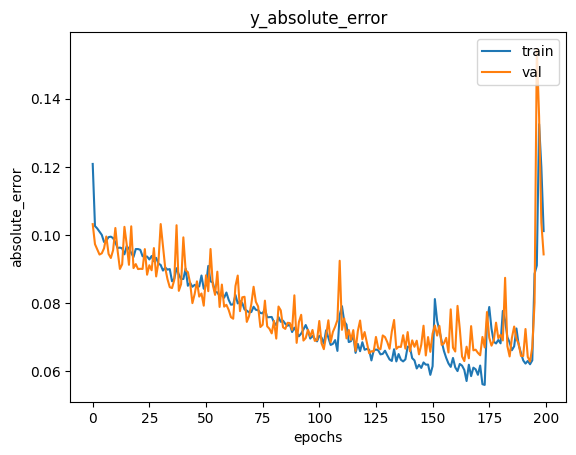

In [38]:
plot_training_history('mean_absolute_error', 'val_mean_absolute_error', history, title='y_absolute_error')

In [32]:
labels_predicted = model.predict(x_train_n)

484/484 [==============================] - 2s 4ms/step


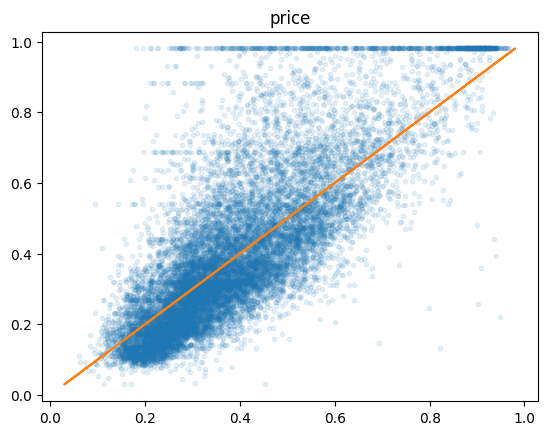

In [41]:
visualize_predictions(labels_predicted, y_train_n)

In [42]:
layer_sizes = [64, 64, 32, 16, 8, 4, 2, 1]
activation = 'selu'
#model = load_model("models/full_20231018_adam")
 
model = initialize_sequential_model(layer_sizes, activation)
model.summary()
model.compile(loss='mean_squared_error', 
              optimizer= tf.keras.optimizers.Adam(),  #"adam" 
              metrics=['mean_absolute_error','mean_absolute_percentage_error']
             )
# fit the keras model on the dataset
history = model.fit(x_train_n[:,:], #training data
                    y_train_n[:],  #Labels
                    epochs=200,
                    batch_size=128,
                    verbose=1,
                    validation_split = 0.1
                   )
model.save("model2_adam")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 64)                576       
                                                                 
 dense_92 (Dense)            (None, 64)                4160      
                                                                 
 dense_93 (Dense)            (None, 32)                2080      
                                                                 
 dense_94 (Dense)            (None, 16)                528       
                                                                 
 dense_95 (Dense)            (None, 8)                 136       
                                                                 
 dense_96 (Dense)            (None, 4)                 36        
                                                                 
 dense_97 (Dense)            (None, 2)                

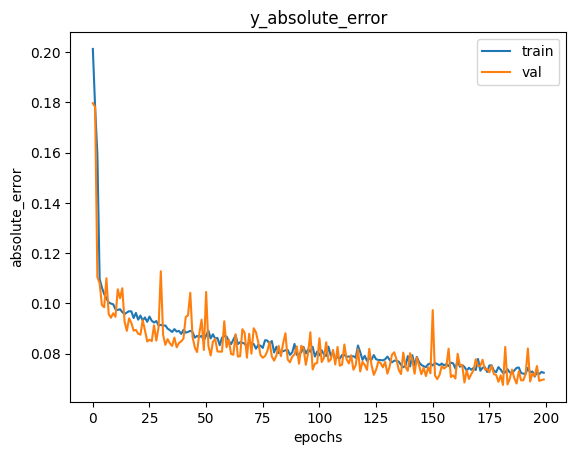

In [61]:
labels_predicted = model.predict(x_train_n)

484/484 [==============================] - 1s 2ms/step
(15480, 1)


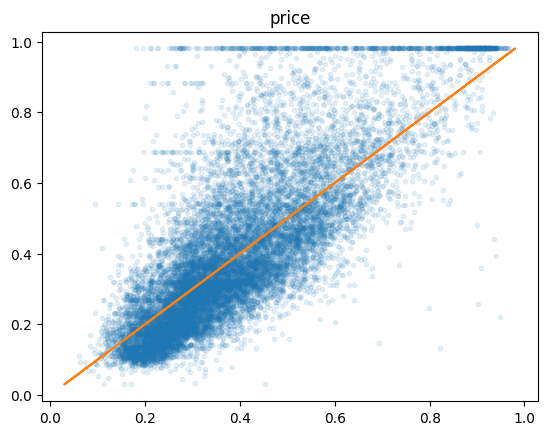

In [34]:
visualize_predictions(labels_predicted, y_train_n)